# Projet SMA Santé : Optimisation Collaborative & Apprentissage par Renforcement

Ce notebook implémente une solution complète pour le problème d'ordonnancement de patients en milieu hospitalier.

### Fonctionnalités Clés :
1. **Modélisation hypercubique** : Axe temps discrétisé (5 min).
2. **Stratégies Hybrides** : Agents AG, Tabou, Recuit Simulé.
3. **Collaboration** : Modes Amis (Partage EMP) vs Ennemis.
4. **Visualisation Complète** :
   - **Gantt** : Planning avant et après optimisation.
   - **Matrice de Diversité** : Distances entre solutions dans l'EMP.
   - **Q-Learning Heatmap** : Visualisation du processus de décision markovien (Q-Table).
5. **Benchmarks** : Génération automatique des tableaux comparatifs.

## 1. Environnement & Modélisation

In [1]:
from typing import Dict, List, Tuple, NamedTuple
import copy
import random
import math

# Configuration globale : Discrétisation en intervalles de 5 minutes
SLOT_DURATION = 5  

class Task(NamedTuple):
    id: int          
    patient_id: int
    op_order: int    # Ordre de l'opération (j)
    skill_req: int   # Compétence requise (médecin/ressource)
    duration: int    # En minutes

class Solution:
    """
    Représente une solution dans le modèle hypercubique.
    Structure: dictionnaire mapping (Patient, Op) -> (Staff_ID, Start_Slot)
    """
    def __init__(self):
        self.schedule: Dict[Tuple[int, int], Tuple[int, int]] = {} 
        self.fitness: float = float('inf')
        self.is_valid: bool = False

class SchedulingEnvironment:
    def __init__(self, data: Dict, skills: List[int], num_patients: int):
        self.data = data 
        self.skills = skills
        self.num_patients = num_patients
        self.tasks: List[Task] = []
        self.tasks_map: Dict[Tuple[int, int], Task] = {}
        self._parse_data()

    def _parse_data(self):
        tid = 0
        for pid, ops in self.data.items():
            for order, task_list in ops.items():
                if task_list:
                    skill, dur = task_list[0]
                    t = Task(tid, pid, order, skill, dur)
                    self.tasks.append(t)
                    self.tasks_map[(pid, order)] = t
                    tid += 1

    def duration_to_slots(self, minutes: int) -> int:
        return (minutes + SLOT_DURATION - 1) // SLOT_DURATION

    def build_initial_solution(self) -> Solution:
        sol = Solution()
        staff_availability = {s: 0 for s in self.skills}
        patient_availability = {p: 0 for p in range(1, self.num_patients + 1)}

        all_tasks = list(self.tasks)
        random.shuffle(all_tasks)
        all_tasks.sort(key=lambda t: t.op_order)
        
        for t in all_tasks:
            staff_id = t.skill_req 
            duration_slots = self.duration_to_slots(t.duration)
            start_time = max(patient_availability[t.patient_id], staff_availability.get(staff_id, 0))
            
            sol.schedule[(t.patient_id, t.op_order)] = (staff_id, start_time)
            finish_time = start_time + duration_slots
            patient_availability[t.patient_id] = finish_time
            staff_availability[staff_id] = finish_time
            
        self.evaluate(sol)
        return sol

    def evaluate(self, solution: Solution) -> float:
        if not solution.schedule:
            solution.fitness = float('inf')
            return float('inf')
            
        max_slot = 0
        for (pid, op), (staff, start) in solution.schedule.items():
            task = self.tasks_map.get((pid, op))
            if task:
                end = start + self.duration_to_slots(task.duration)
                if end > max_slot:
                    max_slot = end
        
        solution.fitness = max_slot
        solution.is_valid = True 
        return max_slot

    def copy_solution(self, solution: Solution) -> Solution:
        new_sol = Solution()
        new_sol.schedule = solution.schedule.copy()
        new_sol.fitness = solution.fitness
        new_sol.is_valid = solution.is_valid
        return new_sol

## 2. Voisinages (Neighborhoods)

In [2]:
class NeighborhoodManager:
    def __init__(self, env: SchedulingEnvironment):
        self.env = env
        self.moves = ['A', 'B', 'C', 'D', 'E']

    def apply_move(self, solution: Solution, move_type: str) -> Solution:
        new_sol = self.env.copy_solution(solution)
        keys = list(new_sol.schedule.keys())
        if not keys: return new_sol

        k1 = random.choice(keys)
        staff1, start1 = new_sol.schedule[k1]
        
        # --- A: Assignment to different medical staff ---
        if move_type == 'A':
            other_staffs = [s for s in self.env.skills if s != staff1]
            if other_staffs:
                new_staff = random.choice(other_staffs)
                new_sol.schedule[k1] = (new_staff, start1)

        # --- B: Successive care tasks assignment ---
        elif move_type == 'B':
            k_next = (k1[0], k1[1] + 1)
            if k_next in new_sol.schedule:
                other_staffs = [s for s in self.env.skills if s != staff1]
                if other_staffs:
                    new_staff = random.choice(other_staffs)
                    new_sol.schedule[k1] = (new_staff, start1)
                    s2, t2 = new_sol.schedule[k_next]
                    new_sol.schedule[k_next] = (new_staff, t2)

        # --- C: Work schedule insertion (Shift/Move) ---
        elif move_type == 'C':
            shift = random.randint(-6, 6) # +/- 30 min
            new_start = max(0, start1 + shift)
            new_sol.schedule[k1] = (staff1, new_start)

        # --- D: Swap two care tasks between different medical staff ---
        elif move_type == 'D':
            candidates = [k for k, v in new_sol.schedule.items() if v[0] != staff1]
            if candidates:
                k2 = random.choice(candidates)
                staff2, start2 = new_sol.schedule[k2]
                new_sol.schedule[k1] = (staff2, start1)
                new_sol.schedule[k2] = (staff1, start2)

        # --- E: Swap between the same medical staff member ---
        elif move_type == 'E':
            candidates = [k for k, v in new_sol.schedule.items() if v[0] == staff1 and k != k1]
            if candidates:
                k2 = random.choice(candidates)
                staff2, start2 = new_sol.schedule[k2]
                new_sol.schedule[k1] = (staff1, start2)
                new_sol.schedule[k2] = (staff1, start1)

        self.env.evaluate(new_sol)
        return new_sol

## 3. Mémoire Partagée (EMP) & Diversité

In [3]:
class SharedMemory:
    def __init__(self, max_size=20, min_dist=2, diversity_threshold=0.5):
        self.solutions: List[Solution] = []
        self.max_size = max_size 
        self.min_dist = min_dist 
        self.dt = diversity_threshold 

    def calculate_distance(self, sol1: Solution, sol2: Solution) -> int:
        """Distance matricielle : Nombre de créneaux différents."""
        dist = 0
        all_keys = set(sol1.schedule.keys()) | set(sol2.schedule.keys())
        for k in all_keys:
            v1 = sol1.schedule.get(k)
            v2 = sol2.schedule.get(k)
            if v1 != v2: 
                dist += 1
        return dist

    def try_insert(self, cs: Solution) -> bool:
        nb = len(self.solutions)
        for s in self.solutions:
            if self.calculate_distance(cs, s) == 0:
                return False

        d_count = 0
        for s in self.solutions:
            if self.calculate_distance(cs, s) >= self.min_dist:
                d_count += 1
        
        ratio = d_count / nb if nb > 0 else 1.0
        inserted = False

        if ratio >= self.dt:
            if nb < self.max_size:
                self.solutions.append(cs)
                inserted = True
            else:
                worst_idx = self._get_worst_idx()
                if worst_idx != -1 and cs.fitness < self.solutions[worst_idx].fitness:
                     self.solutions.pop(worst_idx)
                     self.solutions.append(cs)
                     inserted = True
        else:
            worst_idx = self._get_worst_idx()
            if nb >= self.max_size and worst_idx != -1 and cs.fitness < self.solutions[worst_idx].fitness:
                self.solutions.pop(worst_idx)
                self.solutions.append(cs)
                inserted = True

        if inserted:
            self.solutions.sort(key=lambda x: x.fitness)
            
        return inserted

    def _get_worst_idx(self):
        if not self.solutions: return -1
        vals = [s.fitness for s in self.solutions]
        return vals.index(max(vals))

    def get_best(self):
        if not self.solutions: return None
        return self.solutions[0]

## 4. Q-Learning & Agents

In [4]:
import numpy as np

class QLearningModel:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.actions = actions 
        self.q_table = {} 
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # 0: Amélioration, 1: Stagnation, 2: Dégradation
        self.states = [0, 1, 2]
        
        for s in self.states:
            self.q_table[s] = {a: 0.0 for a in actions}

    def get_state(self, current_fit, prev_fit):
        if prev_fit is None: return 1
        if current_fit < prev_fit: return 0 # Amélioration
        if current_fit == prev_fit: return 1 # Stagnation
        return 2 # Dégradation

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            items = list(self.q_table[state].items())
            random.shuffle(items)
            return max(items, key=lambda x: x[1])[0]

    def update(self, state, action, reward, next_state):
        current_q = self.q_table[state][action]
        max_next_q = max(self.q_table[next_state].values())
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action] = new_q

class MetaheuristicAgent:
    def __init__(self, id, env, strategy_type, use_learning=True):
        self.id = id
        self.env = env
        self.strategy_type = strategy_type 
        self.use_learning = use_learning
        self.current_solution = None
        self.best_solution = None
        self.nm = NeighborhoodManager(env)
        self.brain = QLearningModel(actions=self.nm.moves) if use_learning else None
        self.last_fitness = None

    def initialize(self):
        self.current_solution = self.env.build_initial_solution()
        self.best_solution = self.env.copy_solution(self.current_solution)
        self.last_fitness = self.current_solution.fitness

    def step(self, emp: SharedMemory, collaboration_mode: str):
        # 1. Collaboration
        if collaboration_mode == 'FRIENDS':
            best_shared = emp.get_best()
            if best_shared and best_shared.fitness < self.current_solution.fitness:
                if random.random() < 0.2: 
                    self.current_solution = self.env.copy_solution(best_shared)
        elif collaboration_mode == 'ENEMIES':
            best_shared = emp.get_best()
            if best_shared and best_shared.fitness < self.current_solution.fitness:
                 self.current_solution = self.nm.apply_move(self.current_solution, 'A')

        # 2. Choix Action
        state = 1
        action = 'C'
        if self.use_learning:
            state = self.brain.get_state(self.current_solution.fitness, self.last_fitness)
            action = self.brain.select_action(state)
        else:
            if self.strategy_type == 'AG': action = random.choice(['A', 'B'])
            elif self.strategy_type == 'Tabu': action = random.choice(['C', 'D'])
            else: action = random.choice(['C', 'E'])

        # 3. Mouvement
        prev_fit = self.current_solution.fitness
        new_sol = self.nm.apply_move(self.current_solution, action)
        
        # 4. Acceptation
        accept = False
        if new_sol.fitness <= prev_fit:
            accept = True
        elif self.strategy_type == 'RS' and random.random() < 0.1:
            accept = True
        
        if accept:
            self.current_solution = new_sol
            if new_sol.fitness < self.best_solution.fitness:
                self.best_solution = self.env.copy_solution(new_sol)
                emp.try_insert(self.env.copy_solution(self.best_solution))

        # 5. Update Q-Learning
        if self.use_learning:
            reward = prev_fit - new_sol.fitness 
            next_state = self.brain.get_state(new_sol.fitness, prev_fit)
            self.brain.update(state, action, reward, next_state)
            
        self.last_fitness = self.current_solution.fitness
        return self.best_solution.fitness

class MultiAgentSystem:
    def __init__(self, env, agents_config, mode='FRIENDS'):
        self.env = env
        self.emp = SharedMemory()
        self.mode = mode
        self.agents = []
        for conf in agents_config:
            self.agents.append(MetaheuristicAgent(conf['id'], env, conf['type'], conf['learning']))

    def run(self, iterations=50):
        for a in self.agents: a.initialize()
        history = []
        for i in range(iterations):
            step_res = []
            for a in self.agents:
                fit = a.step(self.emp, self.mode)
                step_res.append(fit)
            history.append(min(step_res))
        return min(history)

## 5. Visualisation (Gantt, Matrices, Q-Table)

Fonctions pour afficher les diagrammes de Gantt, la matrice de diversité et la **Heatmap Q-Learning**.

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import numpy as np

def patient_colors(num_patients):
    """Génère une couleur unique par patient."""
    cmap = plt.get_cmap('tab20')
    return {i: cmap(i % 20) for i in range(1, num_patients + 5)}

def plot_gantt(solution, env, title="Diagramme de Gantt"):
    """Affiche le Gantt d'une solution."""
    if not solution or not solution.schedule:
        print(f"Pas de planning à afficher pour : {title}")
        return

    # Setup Figure
    fig, ax = plt.subplots(figsize=(14, 6))
    skills = sorted(env.skills)
    y_map = {s: i for i, s in enumerate(skills)}
    colors = patient_colors(env.num_patients)
    max_time = 0
    
    # Dessin des barres
    for (pid, op), (staff, start) in solution.schedule.items():
        task = env.tasks_map.get((pid, op))
        if not task: continue
        
        duration = env.duration_to_slots(task.duration)
        end = start + duration
        max_time = max(max_time, end)
        
        y = y_map[staff]
        rect = Rectangle((start, y - 0.4), duration, 0.8, 
                         facecolor=colors[pid], edgecolor='black', alpha=0.8)
        ax.add_patch(rect)
        ax.text(start + duration/2, y, f"P{pid}", 
                ha='center', va='center', color='white', fontsize=8, fontweight='bold')
        
    # Mise en forme
    ax.set_yticks(range(len(skills)))
    ax.set_yticklabels([f"Ressource {s}" for s in skills])
    ax.set_xlim(0, max_time + 5)
    ax.set_xlabel("Temps (Slots de 5 min)")
    ax.set_title(f"{title} (Makespan: {solution.fitness} slots)")
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    legend_elements = [Patch(facecolor=colors[i], label=f'Patient {i}') 
                       for i in range(1, min(env.num_patients+1, 10))]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.01, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def plot_distance_matrix(emp, title="Matrice des Distances (EMP)"):
    """Affiche la matrice des distances des solutions en mémoire."""
    solutions = emp.solutions
    n = len(solutions)
    if n < 2:
        print(f"Pas assez de solutions pour la matrice ({n} solutions).")
        return
        
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = emp.calculate_distance(solutions[i], solutions[j])
            
    fig, ax = plt.subplots(figsize=(8, 7))
    cax = ax.imshow(matrix, cmap='viridis')
    fig.colorbar(cax)
    
    # Annotations
    for i in range(n):
        for j in range(n):
            val = int(matrix[i, j])
            color = "white" if val < np.max(matrix)/2 else "black"
            ax.text(j, i, val, ha="center", va="center", color=color)

    ax.set_title(f"{title} - {n} solutions")
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xlabel("Index Solution")
    ax.set_ylabel("Index Solution")
    plt.tight_layout()
    plt.show()

def plot_q_table_heatmap(agent, title="Q-Table Learning Visualization"):
    """
    Affiche la heatmap de la Q-Table pour visualiser le Processus Markovien.
    Lignes: États (Amélioration, Stagnation, Dégradation)
    Colonnes: Actions (Voisinages A, B, C, D, E)
    """
    if not agent.use_learning or not agent.brain:
        print(f"L'agent {agent.id} n'utilise pas l'apprentissage.")
        return

    q_table = agent.brain.q_table
    states = sorted(q_table.keys())  # [0, 1, 2]
    actions = agent.nm.moves         # ['A', 'B', 'C', 'D', 'E']
    
    # Construction de la matrice
    matrix = np.zeros((len(states), len(actions)))
    for i, s in enumerate(states):
        for j, a in enumerate(actions):
            matrix[i, j] = q_table[s][a]

    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.imshow(matrix, cmap='coolwarm', aspect='auto')
    fig.colorbar(cax, label='Q-Value')

    # Labels
    state_labels = ["Amélioration (0)", "Stagnation (1)", "Dégradation (2)"]
    ax.set_xticks(range(len(actions)))
    ax.set_xticklabels(actions)
    ax.set_yticks(range(len(states)))
    ax.set_yticklabels(state_labels)
    
    # Valeurs dans les cases
    for i in range(len(states)):
        for j in range(len(actions)):
            val = matrix[i, j]
            text_color = "white" if abs(val) > np.max(np.abs(matrix))/2 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color)

    ax.set_title(f"{title} - Agent {agent.id}")
    ax.set_xlabel("Actions (Voisinages)")
    ax.set_ylabel("États du Processus")
    plt.tight_layout()
    plt.show()

## 6. Génération des Données & Benchmarks

In [10]:
from core.data_generator import (
    generate_parametric_data,
    generate_balanced_data,
    generate_realistic_healthcare_data,
    print_data_summary
)

def generate_random_data(num_patients=50, max_ops=2, skills=[1,2,3,4]):
    # Wrapper de compatibilité utilisant le nouveau générateur paramétrique
    data, _ = generate_parametric_data(
        num_patients=num_patients,
        num_skills=len(skills),
        max_operations=max_ops
    )
    return data

def run_benchmark_tables(num_patients=50, iterations=15):
    print(f"\n--- PRÉPARATION BENCHMARK ({num_patients} Patients) ---")
    
    # Utilisation directe du nouveau générateur paramétrique
    data, skills = generate_parametric_data(
        num_patients=num_patients, 
        num_skills=4, 
        max_operations=2
    )
    
    print_data_summary(data, skills)
    
    env = SchedulingEnvironment(data, skills, num_patients)

    print("\n--- Tableau Slide 25 ---")
    print('"Jour","Patients",,"AG_Solo","Tabou_Solo","RS_Solo","SMA_NoLearn","SMA_Learn"')

    ag_solo = MultiAgentSystem(env, [{'id':'AG','type':'AG','learning':False}], mode='ENEMIES').run(iterations)
    tabu_solo = MultiAgentSystem(env, [{'id':'Tabu','type':'Tabu','learning':False}], mode='ENEMIES').run(iterations)
    rs_solo = MultiAgentSystem(env, [{'id':'RS','type':'RS','learning':False}], mode='ENEMIES').run(iterations)

    sma_no_learn = MultiAgentSystem(env, [
        {'id':'1','type':'AG','learning':False},
        {'id':'2','type':'Tabu','learning':False},
        {'id':'3','type':'RS','learning':False}
    ], mode='FRIENDS').run(iterations)

    sma_learn = MultiAgentSystem(env, [
        {'id':'1','type':'AG','learning':True},
        {'id':'2','type':'Tabu','learning':True},
        {'id':'3','type':'RS','learning':True}
    ], mode='FRIENDS').run(iterations)

    print(f'"J1","{num_patients}",,"{ag_solo}","{tabu_solo}","{rs_solo}","{sma_no_learn}","{sma_learn}"')

    print("\n--- Tableau Slide 26 ---")
    print('"SMA sans apprentissage (Amis)",,,,"SMA avec apprentissage (Amis)",,,,"SMA sans apprentissage (Ennemis)",,,,,,,,"SMA avec apprentissage (Ennemis)"')
    print('"AG_Tabou","AG_RS","Tabou_RS","AG_Tabou_RS","AG_Tabou","AG_RS","Tabou_RS","AG_Tabou","AG_RS","Tabou_RS","AG_Tabou_RS", "AG_Tabou","AG_RS","Tabou_RS","AG_Tabou_RS"')
    
    pairs = [
        ([{'id':'1','type':'AG','learning':False},{'id':'2','type':'Tabu','learning':False}], 'FRIENDS'),
        ([{'id':'1','type':'AG','learning':False},{'id':'3','type':'RS','learning':False}], 'FRIENDS'),
        ([{'id':'2','type':'Tabu','learning':False},{'id':'3','type':'RS','learning':False}], 'FRIENDS'),
        ([{'id':'1','type':'AG','learning':False},{'id':'2','type':'Tabu','learning':False},{'id':'3','type':'RS','learning':False}], 'FRIENDS'),
        ([{'id':'1','type':'AG','learning':True},{'id':'2','type':'Tabu','learning':True}], 'FRIENDS'),
        ([{'id':'1','type':'AG','learning':True},{'id':'3','type':'RS','learning':True}], 'FRIENDS'),
        ([{'id':'2','type':'Tabu','learning':True},{'id':'3','type':'RS','learning':True}], 'FRIENDS'),
        ([{'id':'1','type':'AG','learning':True},{'id':'2','type':'Tabu','learning':True},{'id':'3','type':'RS','learning':True}], 'FRIENDS'),
        ([{'id':'1','type':'AG','learning':False},{'id':'2','type':'Tabu','learning':False}], 'ENEMIES'),
        ([{'id':'1','type':'AG','learning':False},{'id':'3','type':'RS','learning':False}], 'ENEMIES'),
        ([{'id':'2','type':'Tabu','learning':False},{'id':'3','type':'RS','learning':False}], 'ENEMIES'),
        ([{'id':'1','type':'AG','learning':False},{'id':'2','type':'Tabu','learning':False},{'id':'3','type':'RS','learning':False}], 'ENEMIES'),
        ([{'id':'1','type':'AG','learning':True},{'id':'2','type':'Tabu','learning':True}], 'ENEMIES'),
        ([{'id':'1','type':'AG','learning':True},{'id':'3','type':'RS','learning':True}], 'ENEMIES'),
        ([{'id':'2','type':'Tabu','learning':True},{'id':'3','type':'RS','learning':True}], 'ENEMIES'),
        ([{'id':'1','type':'AG','learning':True},{'id':'2','type':'Tabu','learning':True},{'id':'3','type':'RS','learning':True}], 'ENEMIES')
    ]

    
    res = []
    for conf, mode in pairs:
        res.append(MultiAgentSystem(env, conf, mode=mode).run(iterations))
        
    print(f'"{res[0]}","{res[1]}","{res[2]}",,"{res[3]}","{res[4]}","{res[5]}","{res[6]}","{res[7]}","{res[8]}","{res[9]}","{res[10]}","{res[11]}","{res[12]}","{res[13]}","{res[14]}","{res[15]}"')

## 7. Exécution & Résultats Complets

   DÉMONSTRATION VISUELLE ET ANALYSE D'UN RUN   

RÉSUMÉ DES DONNÉES GÉNÉRÉES
Nombre de patients    : 50
Nombre de skills      : 4 [1, 2, 3, 4]
Nombre d'opérations   : 70
Nombre de tâches      : 142
Tâches par opération  : 2.03 (moyenne)

Utilisation des compétences:
  Skill 1:  33 tâches ( 23.2%)
  Skill 2:  33 tâches ( 23.2%)
  Skill 3:  36 tâches ( 25.4%)
  Skill 4:  40 tâches ( 28.2%)


> 1. Génération d'une solution initiale (Avant Optimisation)...


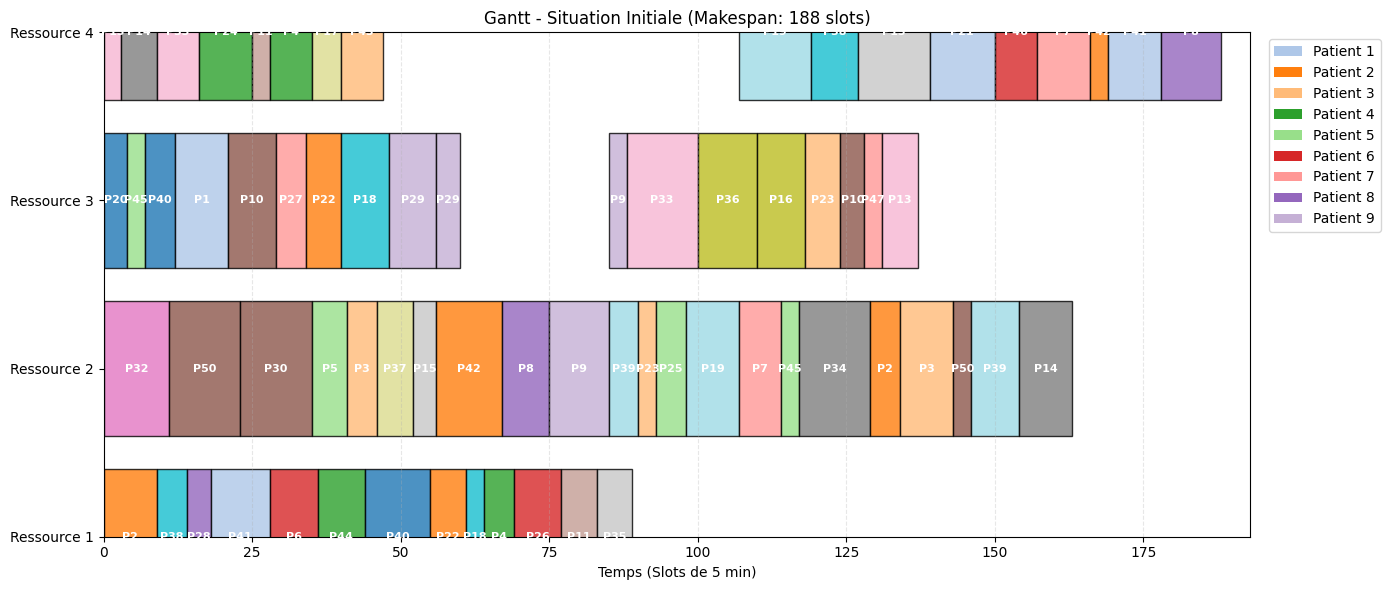


> 2. Lancement de l'optimisation (Mode AMIS, 25 itérations)...

> Meilleure fitness trouvée : 156


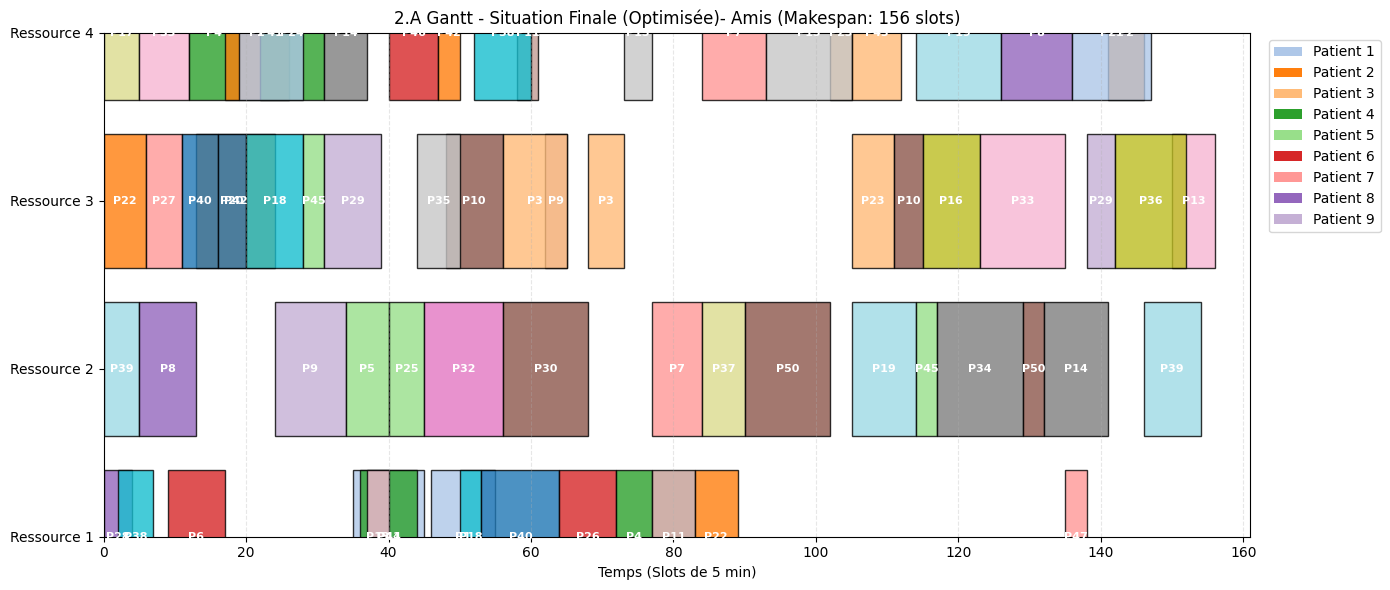


> Meilleure fitness trouvée : 156


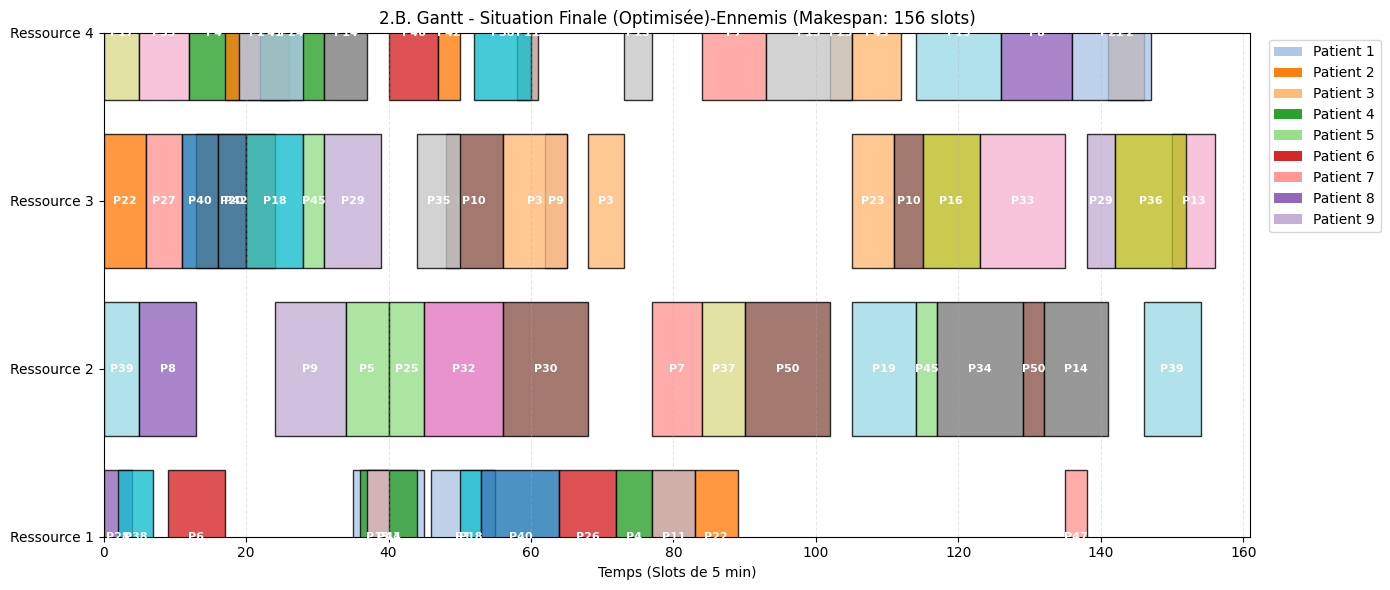


> 3.A Visualisation de la diversité dans la Mémoire Partagée (EMP) - Amis


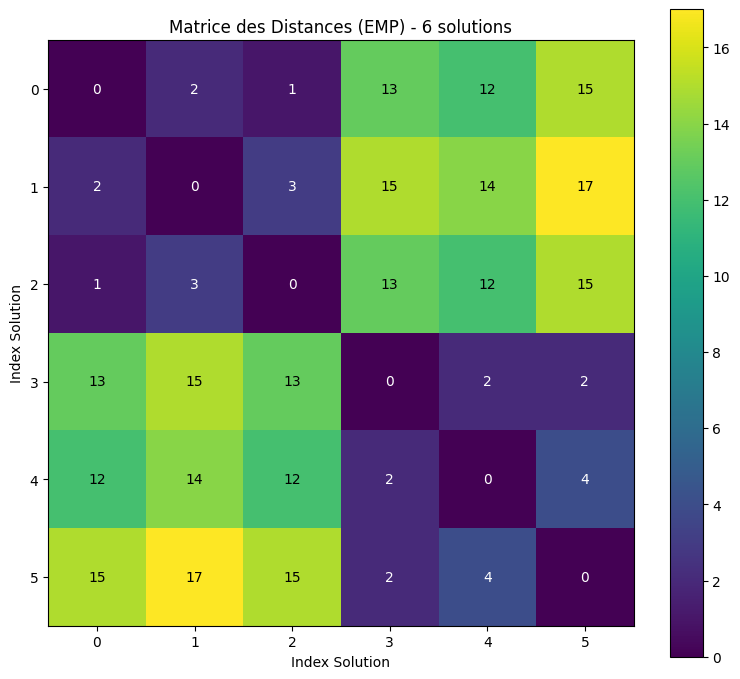


> 3.B Visualisation de la diversité dans la Mémoire Partagée (EMP)- Ennemis
Pas assez de solutions pour la matrice (0 solutions).

> 4.A Visualisation de la Q-Table (Apprentissage de l'Algorithme Génétique) - Amis


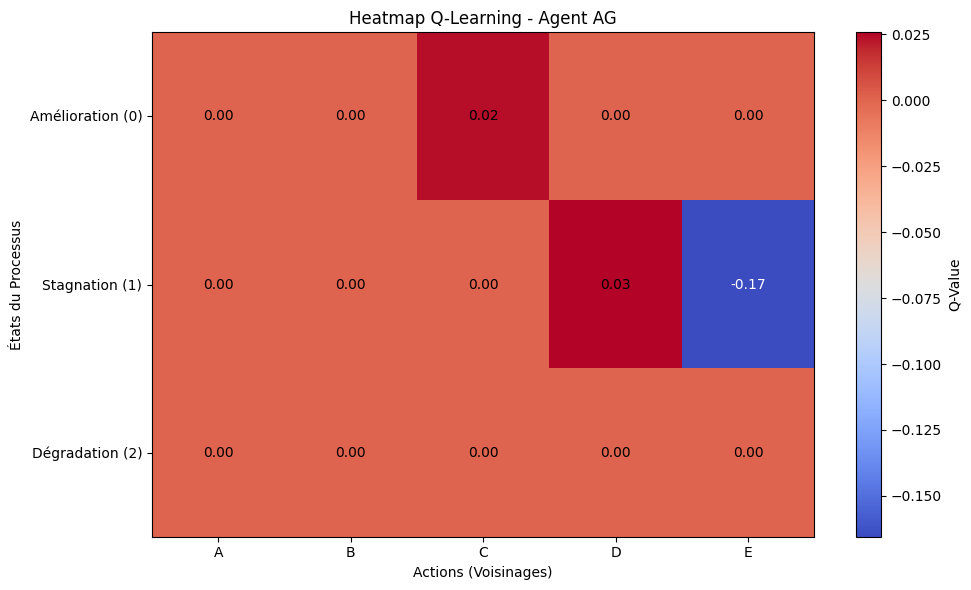


> 4.B Visualisation de la Q-Table (Apprentissage de l'Algorithme Génétique) - Ennemis


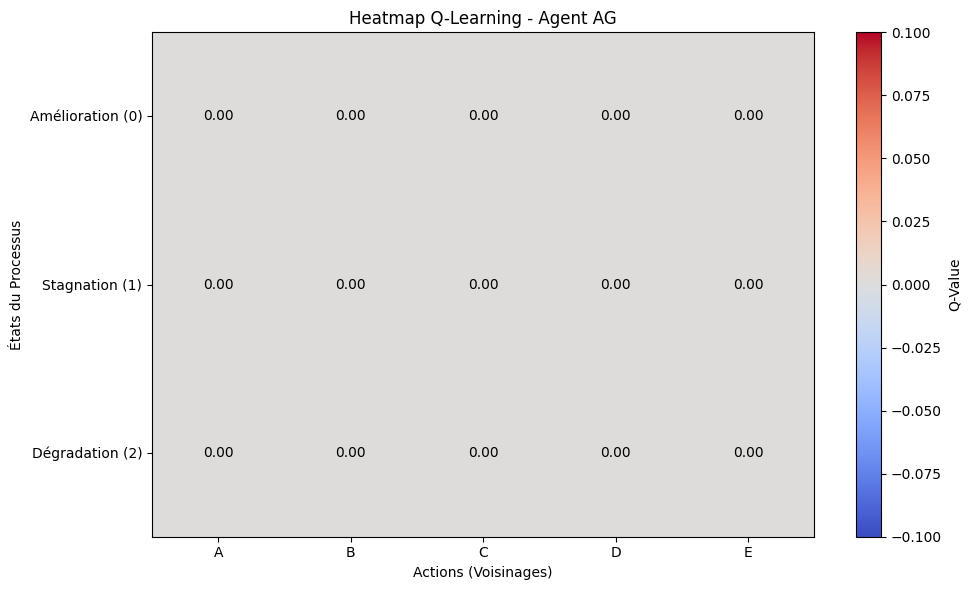


> 5.A Visualisation de la Q-Table (Apprentissage de l'Agent Tabou) - Amis


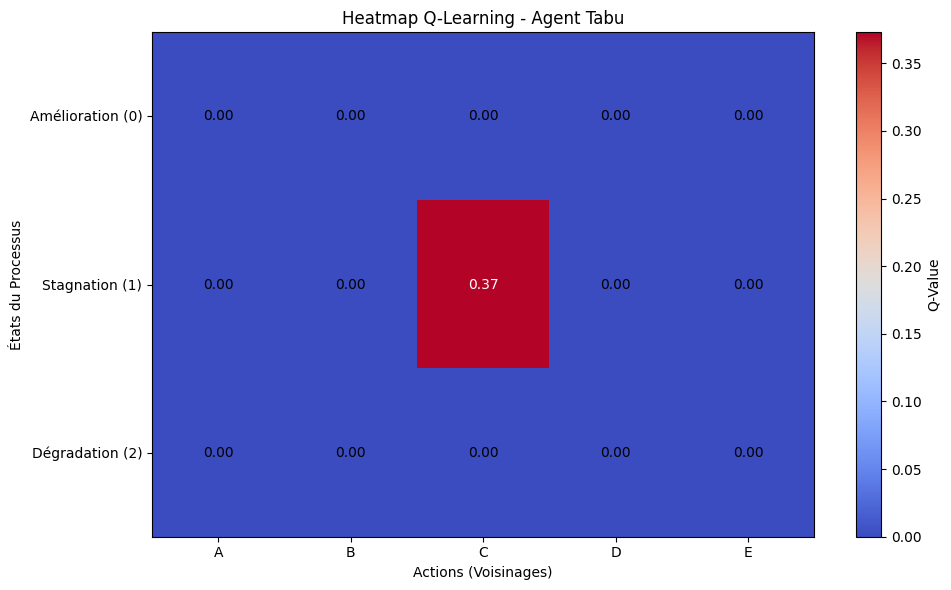


> 5.B Visualisation de la Q-Table (Apprentissage de l'Agent Tabou) - Ennemis


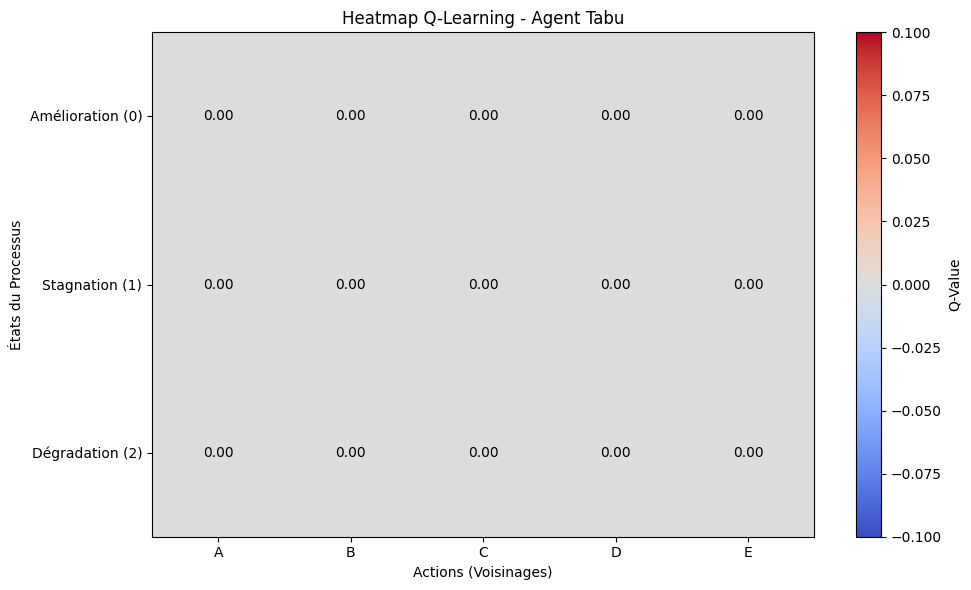


> 6.A Visualisation de la Q-Table (Apprentissage de Recuit Simulé) - Amis


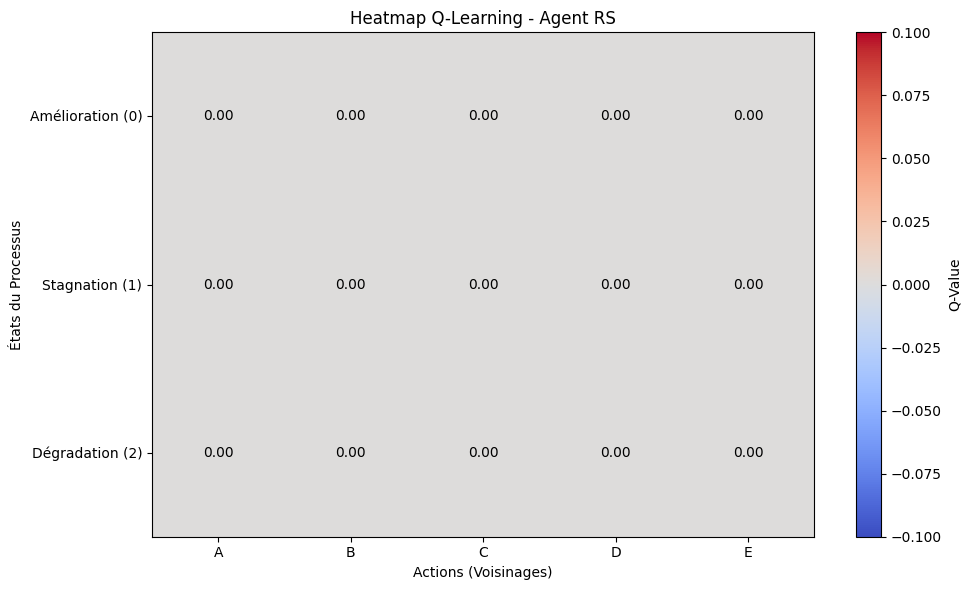


> 6.B Visualisation de la Q-Table (Apprentissage de Recuit Simulé) - Ennemis


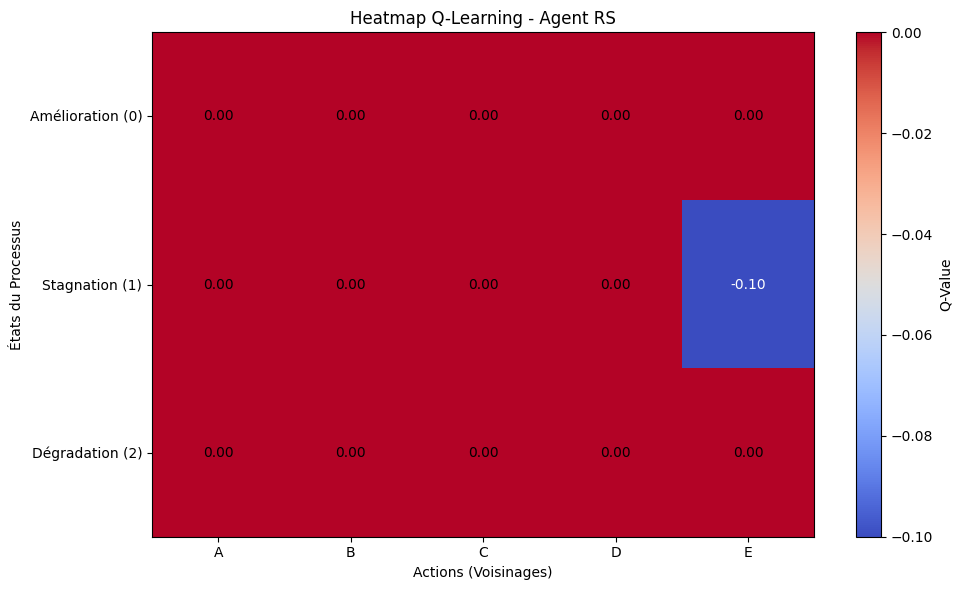



   7. GÉNÉRATION DES TABLEAUX DE BENCHMARK   

--- PRÉPARATION BENCHMARK (50 Patients) ---

RÉSUMÉ DES DONNÉES GÉNÉRÉES
Nombre de patients    : 50
Nombre de skills      : 4 [1, 2, 3, 4]
Nombre d'opérations   : 79
Nombre de tâches      : 153
Tâches par opération  : 1.94 (moyenne)

Utilisation des compétences:
  Skill 1:  31 tâches ( 20.3%)
  Skill 2:  47 tâches ( 30.7%)
  Skill 3:  39 tâches ( 25.5%)
  Skill 4:  36 tâches ( 23.5%)


--- Tableau Slide 25 ---
"Jour","Patients",,"AG_Solo","Tabou_Solo","RS_Solo","SMA_NoLearn","SMA_Learn"
"J1","50",,"165","165","164","165","165"

--- Tableau Slide 26 ---
"SMA sans apprentissage (Amis)",,,,"SMA avec apprentissage (Amis)",,,,"SMA sans apprentissage (Ennemis)",,,,,,,,"SMA avec apprentissage (Ennemis)"
"AG_Tabou","AG_RS","Tabou_RS","AG_Tabou_RS","AG_Tabou","AG_RS","Tabou_RS","AG_Tabou","AG_RS","Tabou_RS","AG_Tabou_RS", "AG_Tabou","AG_RS","Tabou_RS","AG_Tabou_RS"
"165","165","165",,"165","165","165","165","165","165","163","165","165","156","16

In [11]:
# ==========================================
# 1. DÉMONSTRATION VISUELLE (Gantts, Matrice, Q-Learning)
# ==========================================
print("==================================================")
print("   DÉMONSTRATION VISUELLE ET ANALYSE D'UN RUN   ")
print("==================================================")

# 1.1 Setup Demo
demo_patients = 50
data, skills = generate_parametric_data(
    num_patients=demo_patients, 
    num_skills=4, 
    max_operations=2
)
print_data_summary(data, skills)
demo_env = SchedulingEnvironment(data, skills, demo_patients)

# 1.2 Gantt de Départ (Solution Initiale Aléatoire)
print("\n> 1. Génération d'une solution initiale (Avant Optimisation)...")
initial_solution = demo_env.build_initial_solution()
plot_gantt(initial_solution, demo_env, title="Gantt - Situation Initiale")

# 1.3 Exécution du SMA
print("\n> 2. Lancement de l'optimisation (Mode AMIS, 25 itérations)...")
mas_demo = MultiAgentSystem(demo_env, [
    {'id':'AG',   'type':'AG',   'learning':True},
    {'id':'Tabu', 'type':'Tabu', 'learning':True},
    {'id':'RS',   'type':'RS',   'learning':True}
], mode='FRIENDS')

mas_demo2 = MultiAgentSystem(demo_env, [
    {'id':'AG',   'type':'AG',   'learning':True},
    {'id':'Tabu', 'type':'Tabu', 'learning':True},
    {'id':'RS',   'type':'RS',   'learning':True}
], mode='ENEMIES')

mas_demo.run(iterations=25)
mas_demo2.run(iterations=25)

# 1.4 Récupération & Affichage Final
best_sol = None
min_fit = float('inf')
for agent in mas_demo.agents:
    if agent.best_solution.fitness < min_fit:
        min_fit = agent.best_solution.fitness
        best_sol = agent.best_solution

print(f"\n> Meilleure fitness trouvée : {best_sol.fitness}")
plot_gantt(best_sol, demo_env, title="2.A Gantt - Situation Finale (Optimisée)- Amis")

best_sol2 = None
min_fit = float('inf')
for agent in mas_demo2.agents:
    if agent.best_solution.fitness < min_fit:
        min_fit = agent.best_solution.fitness
        best_sol2 = agent.best_solution
        
print(f"\n> Meilleure fitness trouvée : {best_sol.fitness}")
plot_gantt(best_sol, demo_env, title="2.B. Gantt - Situation Finale (Optimisée)-Ennemis")

# 1.5 Visualisation de la Matrice des Distances (EMP)
print("\n> 3.A Visualisation de la diversité dans la Mémoire Partagée (EMP) - Amis")
plot_distance_matrix(mas_demo.emp)

print("\n> 3.B Visualisation de la diversité dans la Mémoire Partagée (EMP)- Ennemis")
plot_distance_matrix(mas_demo2.emp)

# 1.6 Visualisation du Processus Markovien (Q-Table d'un agent)
print("\n> 4.A Visualisation de la Q-Table (Apprentissage de l'Algorithme Génétique) - Amis")
ago = [a for a in mas_demo.agents if a.strategy_type == 'AG'][0]
plot_q_table_heatmap(ago, title="Heatmap Q-Learning")

print("\n> 4.B Visualisation de la Q-Table (Apprentissage de l'Algorithme Génétique) - Ennemis")
ago2 = [a for a in mas_demo2.agents if a.strategy_type == 'AG'][0]
plot_q_table_heatmap(ago2, title="Heatmap Q-Learning")

print("\n> 5.A Visualisation de la Q-Table (Apprentissage de l'Agent Tabou) - Amis")
tabu_agent = [a for a in mas_demo.agents if a.strategy_type == 'Tabu'][0]
plot_q_table_heatmap(tabu_agent, title="Heatmap Q-Learning")

print("\n> 5.B Visualisation de la Q-Table (Apprentissage de l'Agent Tabou) - Ennemis")
tabu_agent2 = [a for a in mas_demo2.agents if a.strategy_type == 'Tabu'][0]
plot_q_table_heatmap(tabu_agent2, title="Heatmap Q-Learning")

print("\n> 6.A Visualisation de la Q-Table (Apprentissage de Recuit Simulé) - Amis")
ro = [a for a in mas_demo.agents if a.strategy_type == 'RS'][0]
plot_q_table_heatmap(ro, title="Heatmap Q-Learning")

print("\n> 6.B Visualisation de la Q-Table (Apprentissage de Recuit Simulé) - Ennemis")
ro2 = [a for a in mas_demo2.agents if a.strategy_type == 'RS'][0]
plot_q_table_heatmap(ro2, title="Heatmap Q-Learning")


# ==========================================
# 2. TABLEAUX DE BENCHMARK (TEXTE)
# ==========================================
print("\n\n==================================================")
print("   7. GÉNÉRATION DES TABLEAUX DE BENCHMARK   ")
print("==================================================")
run_benchmark_tables(num_patients=demo_patients, iterations=25)